In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [6]:
ca = cerberus.read(c_annot)

ca.triplets.head()
ca.triplets.loc[(ca.triplets.gname =='ELN')&(ca.triplets['sample'] == 'h9_chondro')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm
523096,sample_det,ENSG00000049540,2.0,3.0,135.0,278.0,54.000000,0.033898,0.050847,0.915254,ELN,h9_chondro,13063.607422
523096,sample_major,ENSG00000049540,1.0,2.0,31.0,57.0,20.666667,0.042254,0.084507,0.873239,ELN,h9_chondro,13063.607422


In [5]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig2/'

In [3]:
ca = cerberus.read(c_annot)
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


## Plot gene's tpm vs. pi of principal isoform for just ovary

In [11]:
df = ca.triplets.copy(deep=True)
df = df.loc[df.source == 'sample_det']
df = df.loc[df['sample'] == 'ovary']
print(len(df.index))

15100


In [12]:
# only pc genes
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gene_df['gid_stable'] = cerberus.get_stable_gid(gene_df, col='gid')
gene_df.drop(['gid', 'gname'], axis=1, inplace=True)
df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
df = df.loc[df.biotype_category=='protein_coding']
print(len(df.index))

13041


In [13]:
prin_isos = pd.read_csv('../swan/major_feats.tsv', sep='\t')
prin_isos = prin_isos.loc[prin_isos['sample'] == 'ovary']
prin_isos.drop('gname', axis=1, inplace=True)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (0,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
df = df.merge(prin_isos, how='left', on=['gid', 'sample'])
df['log2tpm'] = np.log2(df.gene_tpm+1)

In [15]:
# # only consider genes that express >1 isoform in this sample
# df = df.loc[df.n_iso>1]

In [16]:
df.loc[df.gname == 'COL1A1'][['gname', 'log2tpm', 'gene_tpm', 'tid_pi']]

,gname,log2tpm,gene_tpm,tid_pi
2832,COL1A1,9.100512,547.942749,99.90983


In [17]:
df.loc[df.gname == 'PKM'][['gname', 'log2tpm', 'gene_tpm', 'tid_pi']]

,gname,log2tpm,gene_tpm,tid_pi
803,PKM,8.985638,505.928162,77.95354


In [18]:
df['one_iso'] = df.n_iso==1

In [19]:
c_dict, order = get_biosample_colors()
color = c_dict['ovary']
c_dict = {True: '#b7b7b7', False: color}

In [20]:
x_col = 'tid_pi'
y_col = 'log2tpm'

In [29]:
label_genes = ['PKM', 'COL1A1', 'FOXN3', 'GATA4', 'PAX8']

In [30]:
pi_dict = {'low': 50, 'high': 90}
tpm_dict = {'low': 20, 'high': 100}

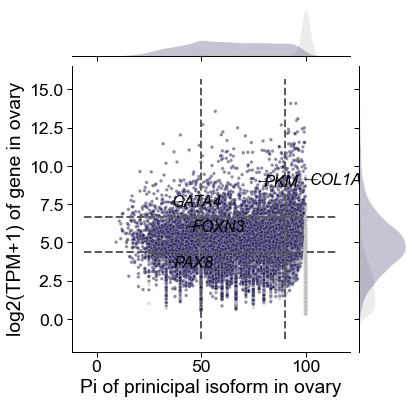

In [32]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
ax = sns.jointplot(data=df, x='tid_pi', y='log2tpm',
                   hue='one_iso',
                   palette=c_dict, size=1, alpha=0.5,
                   marginal_kws={'linewidth':0})
# ax = sns.jointplot(data=df, x='tid_pi', y='log2tpm', kind='hex', color=color)
ax = ax.ax_joint
xlabel = 'Pi of prinicipal isoform in ovary'
ylabel = 'log2(TPM+1) of gene in ovary'
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.get_legend().remove()

for g in label_genes:
    x = df.loc[df.gname == g, x_col].values[0]
    y = df.loc[df.gname == g, y_col].values[0]    
    ax.annotate(g, (x,y), fontsize='small', fontstyle='italic',
                xytext=(4,-4.5), textcoords='offset pixels',
                arrowprops={'width':10, 'headwidth':0})
    # ax.annotate(g, (x,y), fontsize='small', fontstyle='italic',
    #             xytext=(0,0), textcoords='offset pixels')
    
# add sector lines
xlims = ax.get_xlim()
ylims = ax.get_ylim()

# tpm
low_y = math.log2(tpm_dict['low']+1)
high_y = math.log2(tpm_dict['high']+1)

# pi
low_x = pi_dict['low']
high_x = pi_dict['high']
color = '#5c5c5c'
ax.hlines(low_y, xlims[0], xlims[1],
              colors=color, linestyles='dashed',
              linewidth=2)
ax.hlines(high_y, xlims[0], xlims[1],
              colors=color, linestyles='dashed',
              linewidth=2)

ax.vlines(low_x, ylims[0], ylims[1],
              colors=color, linestyles='dashed',
              linewidth=2)
ax.vlines(high_x, ylims[0], ylims[1],
              colors=color, linestyles='dashed',
              linewidth=2)


# fname = '{}/ovary_pi_vs_gene_tpm.pdf'.format(fig_dir)
fname = '{}/testbert.pdf'.format(fig_dir)

plt.savefig(fname, dpi=300)

In [24]:
# quantify how many genes fall within certain thresholds
pi_col = 'tid_pi'
tpm_col = 'gene_tpm'

n = len(df.index)
for pi_key, pi in pi_dict.items():
    for tpm_key, tpm in tpm_dict.items():
        print('{} pi and {} tpm'.format(pi_key, tpm_key))
        if pi_key == 'low':
            temp = df.loc[df[pi_col]<pi].copy(deep=True)
            pi_label = '<'
        elif pi_key == 'high':
            temp = df.loc[df[pi_col]>pi].copy(deep=True)
            pi_label = '>'
        if tpm_key == 'low':
            temp = temp.loc[temp[tpm_col]<tpm]
            tpm_label = '<'
        elif tpm_key == 'high':
            temp = temp.loc[temp[tpm_col]>tpm]
            tpm_label = '>'
        n_num = len(temp.index)
        print('{:.2f}% ({}/{}) of protein coding genes in ovary have pi {} {} and tpm {} {}'.format((n_num/n)*100, n_num, n, pi_label, pi, tpm_label, tpm))
        print()

low pi and low tpm
6.51% (849/13041) of protein coding genes in ovary have pi < 50 and tpm < 20

low pi and high tpm
2.19% (285/13041) of protein coding genes in ovary have pi < 50 and tpm > 100

high pi and low tpm
20.88% (2723/13041) of protein coding genes in ovary have pi > 90 and tpm < 20

high pi and high tpm
2.93% (382/13041) of protein coding genes in ovary have pi > 90 and tpm > 100



In [27]:
df.loc[(df.tid_pi<pi_dict['low'])&(df.gene_tpm<tpm_dict['low'])][['gname', 'gene_tpm', 'log2tpm', 'tid_pi', 'tf']].head(40)
df.loc[(df.tid_pi<pi_dict['low'])&(df.gene_tpm<tpm_dict['low'])&(df.tf==True)][['gname', 'gene_tpm', 'log2tpm', 'tid_pi', 'tf']].head(40)


,gname,gene_tpm,log2tpm,tid_pi,tf
185,ETV7,3.485603,2.165302,46.153847,True
376,TFB1M,18.142603,4.258715,47.222220,True
1214,ZNF506,12.506409,3.755572,41.666664,True
1506,ZNF268,17.259434,4.190570,33.333336,True
1544,ESR1,10.977780,3.582289,33.333336,True
2194,ZNF500,17.840191,4.235742,45.714287,True
2409,ZNF419,16.677288,4.143825,31.428572,True
2469,DBP,16.255630,4.108995,44.444447,True
2844,HLF,18.249863,4.266776,45.238094,True
2883,ELF2,15.031131,4.002804,26.315790,True


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


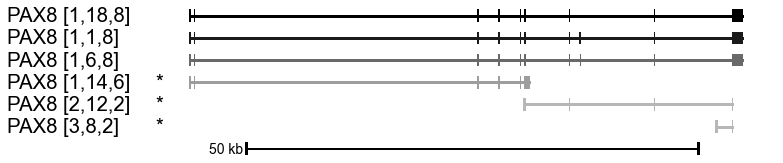

In [28]:
gene ='PAX8'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')


In [156]:
df.loc[(df.tid_pi<pi_dict['low'])&(df.gene_tpm>tpm_dict['high'])][['gname', 'gene_tpm', 'log2tpm', 'tid_pi', 'tf']].head(40)
df.loc[(df.tid_pi<pi_dict['low'])&(df.gene_tpm>tpm_dict['high'])&(df.tf==True)][['gname', 'gene_tpm', 'log2tpm', 'tid_pi', 'tf']].head(40)

,gname,gene_tpm,log2tpm,tid_pi,tf
2233,MAZ,149.227646,7.231007,42.367600,True
3554,NFE2L2,156.310120,7.297468,39.152542,True
3791,FOXO3,126.690216,6.996504,31.460676,True
4904,ZNF331,204.941071,7.686088,26.520681,True
5603,GATA4,199.088608,7.644495,34.007350,True
6058,TCF12,107.840759,6.766075,28.648647,True
6191,GATA6,198.567398,7.640732,32.859177,True
6242,NFIC,327.426086,8.359425,41.847206,True
8858,PBX3,137.806519,7.116931,34.597157,True
9134,STAT3,187.051453,7.554984,35.772358,True


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


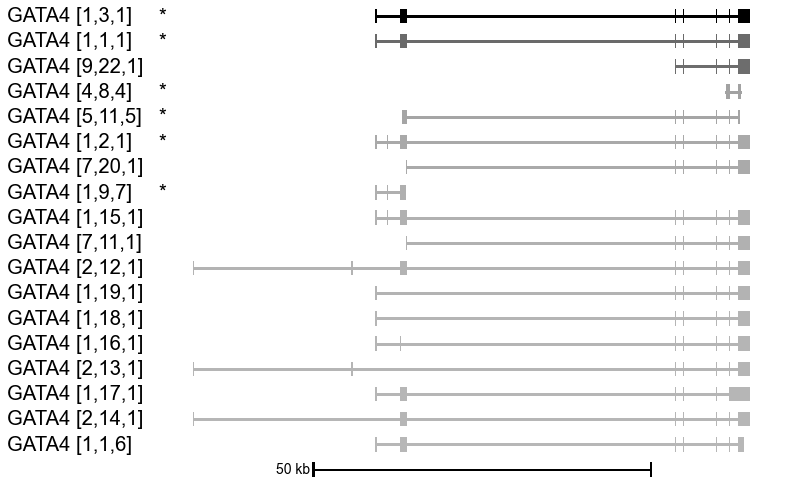

In [7]:
gene ='GATA4'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


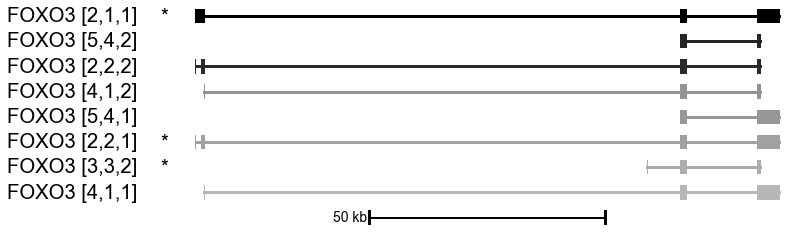

In [6]:
gene ='FOXO3'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


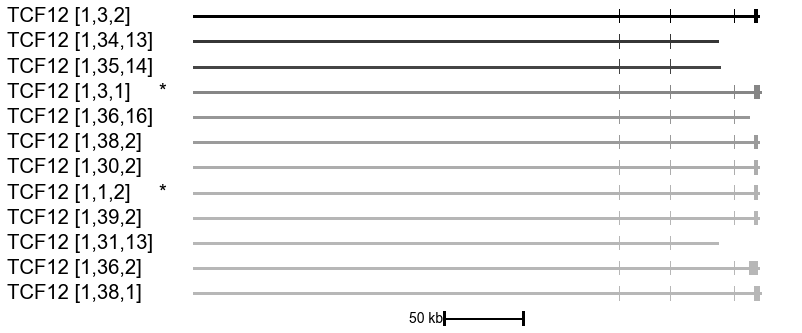

In [5]:
gene ='TCF12'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')
plt.savefig('figures/tcf12_browser.pdf', dpi=300)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


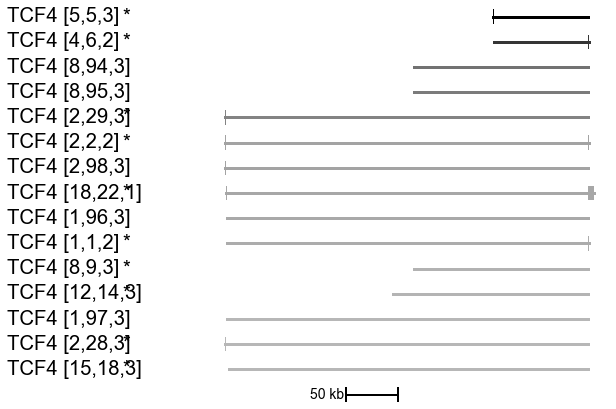

In [4]:
gene ='TCF4'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')
plt.savefig('figures/tcf4_browser.pdf', dpi=300)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


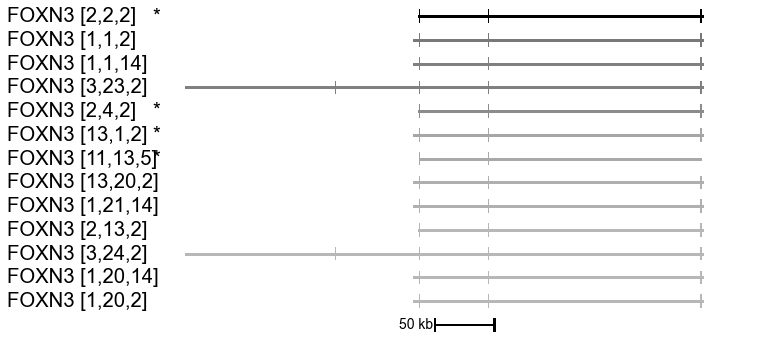

In [47]:
gene ='FOXN3'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


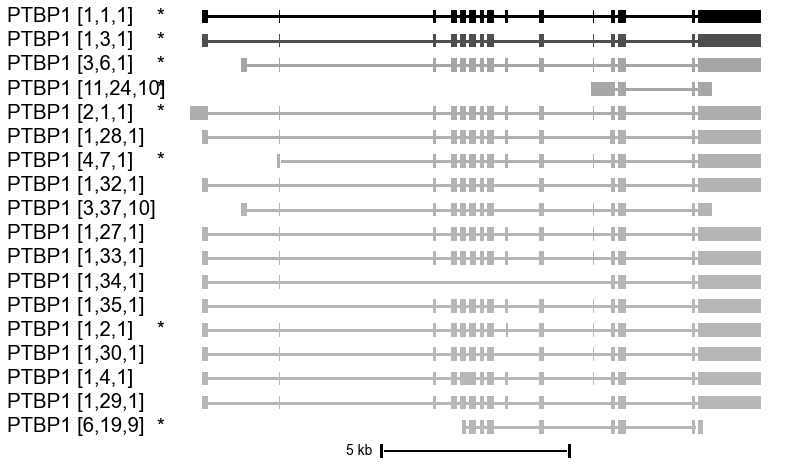

In [48]:
gene ='PTBP1'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

## Plot gene's tpm vs. number of isoforms


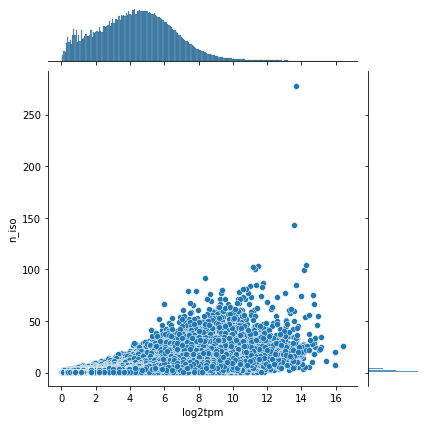

In [12]:
df = ca.triplets.copy(deep=True)
df = df.loc[df.source == 'sample_det'] 
df['log2tpm'] = np.log2(df.gene_tpm+1)
# sns.jointplot(data=df, x='log2tpm', y='n_iso', kind='hex', xlim=(0,6), ylim=(0,50))
# sns.jointplot(data=df, x='log2tpm', y='n_iso', xlim=(0,6), ylim=(0,50))
sns.jointplot(data=df, x='log2tpm', y='n_iso')

## Plotting relevant genes

In [4]:
# gene = 'UBXN1'
# obs_col = 'sample'
# obs_condition = 'ovary'
# ax, tpm_df = plot_browser_isos(ca, sg, gene,
#                              obs_col, obs_condition,
#                              filt_ab, major_set,
#                              h=0.2, ref_source='v40')

## Finding relevant genes

In [47]:
def get_med_exons_per_gene(ca):
    """
    Get the median number of exons per gene across 
    all identified transcripts in cerberus
    """
    exon_df = ca.t_map[['transcript_id']]
    exon_df = add_feat(exon_df, kind='ic', col='transcript_id')
    exon_df.drop_duplicates(inplace=True)
    
    # merge w/ ic table to get # exons
    exon_df = exon_df.merge(ca.ic[['Name', 'Coordinates']],
                        how='left',
                        left_on='ic',
                        right_on='Name')
    exon_df['n_exons'] = exon_df['Coordinates'].str.count('-')
    exon_df.loc[exon_df.Coordinates=='-', 'exon_df'] = 0
    
    # get gene id and compute median
    exon_df['gid'] = exon_df.ic.str.split('_', expand=True)[0]
    gene_exon_df = exon_df[['gid', 'n_exons']].groupby('gid').median().reset_index()
    gene_exon_df.rename({'n_exons': 'median_exons'}, axis=1, inplace=True)
    
    return gene_exon_df

In [81]:
ca = cerberus.read(c_annot)
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


In [82]:
obs_col = 'sample'
tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
tpm_df = tpm_df.transpose()

In [85]:
tpm_df.reset_index(inplace=True)
tpm_df.loc[tpm_df['index'].str.contains('ENSG00000108821'),['index', 'ovary']]

,index,ovary
187994,"ENSG00000108821[1,1,12]",412.205261
187995,"ENSG00000108821[1,1,13]",0.000000
187996,"ENSG00000108821[1,1,14]",0.000000
187997,"ENSG00000108821[1,1,1]",0.000000
187998,"ENSG00000108821[1,15,14]",0.000000
187999,"ENSG00000108821[13,14,1]",0.000000
188000,"ENSG00000108821[2,2,2]",0.000000
188001,"ENSG00000108821[7,7,6]",0.000000
188002,"ENSG00000108821[8,8,8]",0.220271


## 1,1,1 isoform

In [66]:
# get all sample det isoforms
source = 'sample_det'
df = ca.triplets.loc[ca.triplets.source == source]

# get triplet id and limit to 1,1,1 genes
df['triplet'] = df.n_tss.astype(int).astype(str)+','+\
                df.n_ic.astype(int).astype(str)+','+\
                df.n_tes.astype(int).astype(str)
df = df.loc[df.triplet == '1,1,1']

# get the median number of exons per gene
ge_df = get_med_exons_per_gene(ca)
df = df.merge(ge_df, how='left', on='gid')
              
# remove genes without a lot of exons
df = df.loc[df.median_exons > 3]
              
df.sort_values(by='gene_tpm', ascending=False).head(20)              

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,triplet,median_exons
84888,sample_det,ENSG00000164879,1.0,1.0,1.0,1.0,1.0,CA3,muscle,1181.528564,"1,1,1",5.0
110312,sample_det,ENSG00000142676,1.0,1.0,1.0,1.0,1.0,RPL11,mcf7,1067.494995,"1,1,1",7.0
167491,sample_det,ENSG00000142676,1.0,1.0,1.0,1.0,1.0,RPL11,hl60,941.440308,"1,1,1",7.0
168037,sample_det,ENSG00000171314,1.0,1.0,1.0,1.0,1.0,PGAM1,hl60,941.217407,"1,1,1",5.0
139089,sample_det,ENSG00000171314,1.0,1.0,1.0,1.0,1.0,PGAM1,adipose,843.580444,"1,1,1",5.0
84309,sample_det,ENSG00000143318,1.0,1.0,1.0,1.0,1.0,CASQ1,muscle,793.289673,"1,1,1",15.0
151674,sample_det,ENSG00000142676,1.0,1.0,1.0,1.0,1.0,RPL11,panc1,748.990295,"1,1,1",7.0
47977,sample_det,ENSG00000148965,1.0,1.0,1.0,1.0,1.0,SAA4,liver,743.821594,"1,1,1",5.0
48175,sample_det,ENSG00000157131,1.0,1.0,1.0,1.0,1.0,C8A,liver,721.939087,"1,1,1",13.0
126781,sample_det,ENSG00000142676,1.0,1.0,1.0,1.0,1.0,RPL11,pc3,709.075439,"1,1,1",7.0


In [63]:
ca.triplets.loc[(ca.triplets.source == 'sample_det')&(ca.triplets.gname=='COL1A1')].sort_values(by='gene_tpm', ascending=False)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm
525202,sample_det,ENSG00000108821,3.0,5.0,4.0,7.0,1.000000,COL1A1,h9_chondro,63934.390625
140365,sample_det,ENSG00000108821,2.0,3.0,2.0,4.0,0.800000,COL1A1,pgp1_astro,17760.802734
128010,sample_det,ENSG00000108821,2.0,2.0,2.0,2.0,1.000000,COL1A1,imr90,9858.122070
487597,sample_det,ENSG00000108821,2.0,3.0,2.0,3.0,0.800000,COL1A1,hffc6,1834.368774
210700,sample_det,ENSG00000108821,2.0,3.0,2.0,3.0,0.800000,COL1A1,vessels,680.690735
252630,sample_det,ENSG00000108821,1.0,1.0,1.0,1.0,1.000000,COL1A1,ovary,547.942749
572436,sample_det,ENSG00000108821,2.0,2.0,2.0,2.0,1.000000,COL1A1,h9_osteocyte,442.539429
58620,sample_det,ENSG00000108821,1.0,2.0,1.0,2.0,0.666667,COL1A1,lung,175.406296
466298,sample_det,ENSG00000108821,1.0,1.0,1.0,1.0,1.000000,COL1A1,adipose,131.496017
87306,sample_det,ENSG00000108821,1.0,2.0,1.0,2.0,0.666667,COL1A1,colon,131.359818


## Highly-expressed non 1,1,1 isoform

In [5]:
source = 'sample_det'
# source = 'sample_major'
df = ca.triplets.loc[ca.triplets.source == source]

In [6]:
# get triplet id and limit to non 1,1,1 genes
df['triplet'] = df.n_tss.astype(int).astype(str)+','+\
                df.n_ic.astype(int).astype(str)+','+\
                df.n_tes.astype(int).astype(str)
df = df.loc[df.triplet != '1,1,1']
print(df.head())

# let's try to get genes w/ a lot of ic variation
# df = df.loc[df.n_ic > 5]

# add tf designation
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gene_df['gid_stable'] = cerberus.get_stable_gid(gene_df, 'gid')
df = df.merge(gene_df[['tf', 'gid_stable']],
              how='left', left_on='gid',
              right_on='gid_stable', 
              suffixes=('', '_gtf'))

       source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
0  sample_det  ENSG00000000003    1.0    5.0   6.0   18.0             2.0   
1  sample_det  ENSG00000000419    1.0    4.0   8.0   11.0             3.2   
2  sample_det  ENSG00000000457    1.0    2.0   3.0    4.0             2.0   
3  sample_det  ENSG00000000460    2.0    1.0   3.0    4.0             2.0   
4  sample_det  ENSG00000001036    1.0    4.0   6.0   11.0             2.4   

      gname sample    gene_tpm triplet  
0    TSPAN6  caco2  347.757385   1,6,5  
1      DPM1  caco2  126.812943   1,8,4  
2     SCYL3  caco2   10.705085   1,3,2  
3  C1orf112  caco2   17.822382   2,3,1  
4     FUCA2  caco2  261.958191   1,6,4  


In [7]:
df.loc[df['sample']=='ovary'].sort_values(by='gene_tpm', ascending=False)
df.loc[(df['sample']=='ovary')&(df.gene_tpm>500)&(df.tf==True)]
df.loc[(df['sample']=='ovary')&(df.gene_tpm>500)&(df.gene_tpm<600)]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,gname,sample,gene_tpm,triplet,tf,gid_stable
170970,sample_det,ENSG00000044574,1.0,3.0,3.0,5.0,1.500000,HSPA5,ovary,538.201477,"1,3,3",False,ENSG00000044574
171160,sample_det,ENSG00000064666,4.0,3.0,12.0,12.0,3.428571,CNN2,ovary,576.006104,"4,12,3",False,ENSG00000064666
171239,sample_det,ENSG00000067225,5.0,2.0,17.0,18.0,4.857143,PKM,ovary,505.928162,"5,17,2",False,ENSG00000067225
171716,sample_det,ENSG00000087460,9.0,2.0,17.0,19.0,3.090909,GNAS,ovary,500.949036,"9,17,2",False,ENSG00000087460
171928,sample_det,ENSG00000099204,1.0,3.0,6.0,11.0,3.000000,ABLIM1,ovary,527.211304,"1,6,3",False,ENSG00000099204
172286,sample_det,ENSG00000102144,3.0,4.0,7.0,12.0,2.000000,PGK1,ovary,559.527588,"3,7,4",False,ENSG00000102144
172520,sample_det,ENSG00000104870,4.0,1.0,14.0,18.0,5.600000,FCGRT,ovary,511.226379,"4,14,1",False,ENSG00000104870
172686,sample_det,ENSG00000106211,2.0,1.0,2.0,3.0,1.333333,HSPB1,ovary,557.116089,"2,2,1",False,ENSG00000106211
172738,sample_det,ENSG00000106682,1.0,2.0,5.0,5.0,3.333333,EIF4H,ovary,599.049255,"1,5,2",False,ENSG00000106682
172887,sample_det,ENSG00000108679,3.0,2.0,5.0,6.0,2.000000,LGALS3BP,ovary,526.019836,"3,5,2",False,ENSG00000108679


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import subprocess

p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [3]:
print('test')

test


In [4]:
major_set = '../swan/isos_sample_gene_90.tsv'
c_annot = 'cerberus_annot_triplets.h5'
gtf = '../cerberus.gtf'
swan_file = '../swan/swan.p'
filt_ab = '../cerberus_filtered_abundance.tsv'
h5 = '../cerberus_annot.h5'
ca = cerberus.read(c_annot)
sg = swan.read(swan_file)
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig2'

Read in graph from ../swan/swan.p


## Browser plots

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


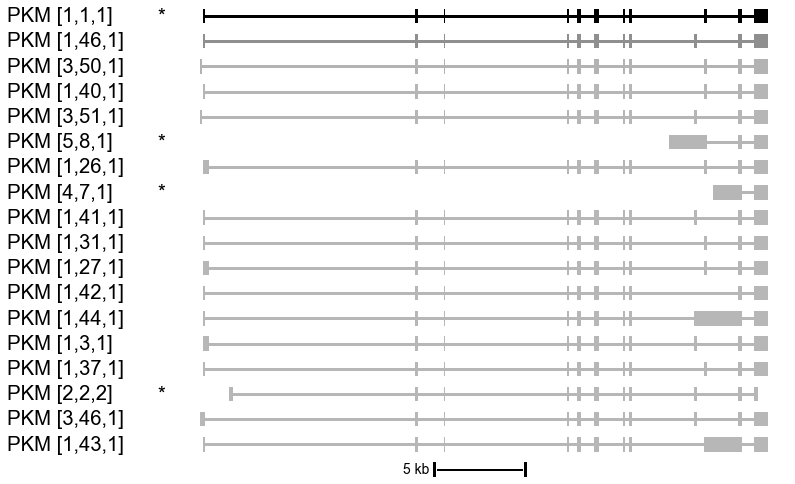

In [5]:
gene = 'PKM'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

fname = 'figures/{}_{}_major_isos_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

fname = '{}/{}_{}_major_isos_browser.pdf'.format(fig_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


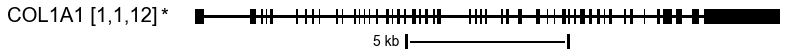

In [6]:
gene = 'COL1A1'
obs_col = 'sample'
obs_condition = 'ovary'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

fname = 'figures/{}_{}_major_isos_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

fname = '{}/{}_{}_major_isos_browser.pdf'.format(fig_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=300)

In [4]:
df = pd.read_csv(major_set, sep='\t')

In [6]:
df = df.loc[df.gname=='COL1A1']

In [9]:
df = df[['tid', 'pi_rank', 'sample']]
df = df.groupby(['tid', 'pi_rank']).count().sort_values(by='pi_rank').reset_index()

In [10]:
df

,tid,pi_rank,sample
0,"ENSG00000108821[1,1,12]",1,19
1,"ENSG00000108821[1,1,14]",1,8
2,"ENSG00000108821[13,14,1]",1,1
3,"ENSG00000108821[1,1,12]",2,3
4,"ENSG00000108821[1,1,14]",2,1


In [11]:
t_df, _, _ = get_gtf_info(how='iso')

In [15]:
t_df.head()

,tid,t_len,gid,gname,biotype,biotype_category,tf
0,"ENSG00000000003[1,1,1]",3876,ENSG00000000003.15,TSPAN6,protein_coding,protein_coding,False
1,"ENSG00000000003[1,4,3]",1248,ENSG00000000003.15,TSPAN6,protein_coding,protein_coding,False
2,"ENSG00000000003[2,2,1]",3904,ENSG00000000003.15,TSPAN6,protein_coding,protein_coding,False
3,"ENSG00000000003[2,3,2]",1007,ENSG00000000003.15,TSPAN6,protein_coding,protein_coding,False
4,"ENSG00000000003[3,5,4]",926,ENSG00000000003.15,TSPAN6,protein_coding,protein_coding,False


,tid,t_len,gid,gname,biotype,biotype_category,tf


In [17]:
t_df = pd.read_csv('../cerberus_transcript_metadata.tsv', sep='\t')

In [19]:
t_df.loc[t_df.tid.isin(['ENSG00000108821[1,1,12]', 'ENSG00000108821[1,1,14]'])]

,tid,t_len,gid,gname,biotype,biotype_category,tf
48846,"ENSG00000108821[1,1,12]",6878,ENSG00000108821.13,COL1A1,protein_coding,protein_coding,False
48848,"ENSG00000108821[1,1,14]",4929,ENSG00000108821.13,COL1A1,protein_coding,protein_coding,False
